# CME538 - Introduction to Data Science

## Tutorial 9 - Feature Selection, Hyper-Parameter Tuning, and Regularization
By Navid Kayhani and Marc Saleh

-





This notebook is mainly based on:

[[1]](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial) Titanic - Advanced Feature Engineering Tutorial



<a id='section0'></a>
## Setup Notebook
First, we need to import the Python packages we plan to use.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# generate confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Logestic Regresion
from sklearn.linear_model import LogisticRegression
#Metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

#model selection
from sklearn.model_selection import StratifiedKFold

# Configure Notebook
#for plots to be inline
%matplotlib inline 
#for auto_complete 
%config Completer.use_jedi = False 
# import warnings

# warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_context("notebook")

<a id='section1'></a>

# Reading data and exploratory data analysis

## Read in data

The next step after importing the requried Python packages is to import the dataset. We use the titanic dataset for this tutorial. 

In [2]:
df_titanic = ...
df_titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now let's look at the dataset using `info()` method

In [3]:
...

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Let me provide more information about each column 

* `PassengerId` passenger unique id (index)
* `Survived` target variable (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = First Class**
    - **2 = Premium Economy Class**
    - **3 = Economy Class**
* `Name` last name, title, first name
* `Sex` (Passenger gender) categorical feature
* `Age` here a float
* `SibSp` total number of the passengers' siblings and spouse
* `Parch` total number of the passengers' parents and children
* `Ticket` ticket number 
* `Fare` fare paid by the passenger 
* `Cabin` cabin number
* `Embarked` (Embarkation point) a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg, France**
    - **Q = Queesntown, Ireland (present day Cobh, Ireland)**
    - **S = Southampton, U.K.**

## Data Cleaning

### **Missing Values**

Some columns have missing values.

In [4]:
...

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Roughly **78%** of the values in `Cabin` is missing. Missing values in `Age`, `Embarked` can be filled with a descriptive statistical measure but that wouldn't work for `Cabin`.

####  Age

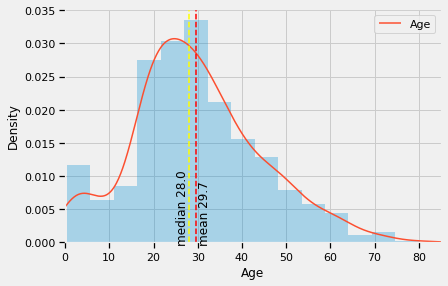

In [5]:
# Plot age distribution
ax = ...
#plot density
...


ax.set(xlabel='Age')
plt.axvline(x=..., color = 'red', ls='--')
plt.axvline(x=..., color = 'yellow', ls='--')
plt.text(30.1,0,'mean {}'.format(...,rotation=90)
plt.text(25.1,0,'median {}'.format(...),rotation=90)


plt.legend()
plt.xlim(0,85)
plt.show()

`Age` is (right) skewed, using the mean might give us biased ages towards older ages. Using the median to impute the missing values might be a better idea. However, let's see a more involved approach for imputing missing values.

Let's check which feature is more correlated with `Age` and calculate the median based on that feature 

In [6]:
...

Age         1.000000
Pclass      0.369226
SibSp       0.308247
Parch       0.189119
Fare        0.096067
Survived    0.077221
Name: Age, dtype: float64

Let's see if the medians are actually different for different `Pclass`

In [7]:
...

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

Let's also examine categorical features like `Sex` 

In [8]:
...

Sex
female    27.0
male      29.0
Name: Age, dtype: float64

Now let's combine them

In [9]:
...

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

They seem like meaningful categories, so let's keep that. The higher `Pclass`, the higher the median `Age` for both males and females. However, females tend to have slightly lower median `Age` than males. Now, let's fill the missing values in `age` feature by the above values. 

In [10]:
# Filling the missing values in Age with the medians of Sex and Pclass groups
df_titanic['Age'] = ...
df_titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

#### Embarked

`Embarked` is a categorical feature and there are only **2** missing values. Let's see what they are

In [11]:
...

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We can just impute with the port where most people boarded

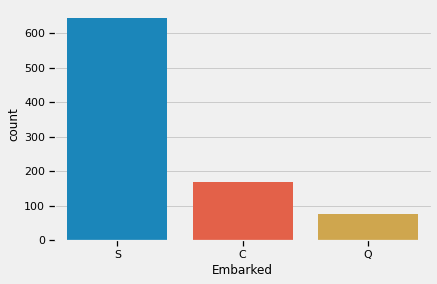

In [12]:
# check distribution of embarked value
sns.countplot(...)
plt.show()

Missing values in `Embarked` are filled with *S*.

In [13]:
# Filling the missing values in Embarked with S
...

#### Cabin

Many `Cabin` values are missing. Let's drop the feature

In [14]:
# Dropping the Cabin feature
...

Now we have handled the missing values in `Age`, `Embarked`, and `Cabin` features, and there is not missing values anymore. 

### EDA

Let's look at the target variable distribution  

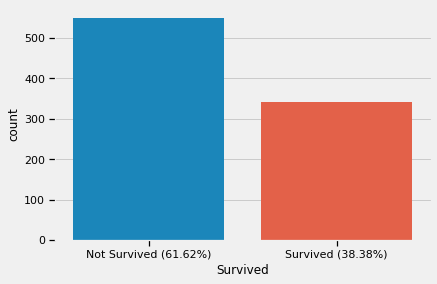

In [22]:
# Target variable (Survived)
survived = ...
not_survived = ...
survived_per = survived / df_titanic.shape[0] * 100
not_survived_per = not_survived / df_titanic.shape[0] * 100
sns.countplot(x='Survived', data=df_titanic)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.show()

### **Correlations**
Many features are correlated with each other. The highest correlation between features is between between `Fare` and `Pclass`, as expected. Also, `SibSp` and `Parch` are highly correlated and show the size of a family. 

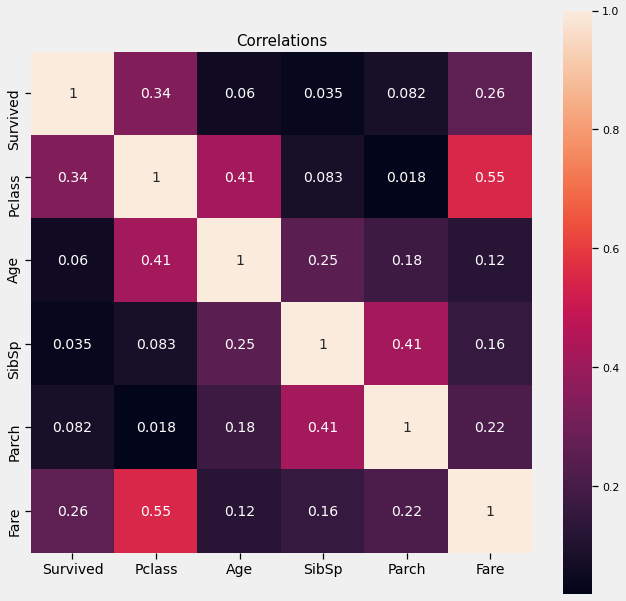

In [33]:
fig, axs = plt.subplots( figsize=(10, 10))

sns.heatmap(..., annot_kws={'size': 14})   
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
    
axs.set_title('Correlations', size=15)

plt.show()

### **Target Distribution in Features**

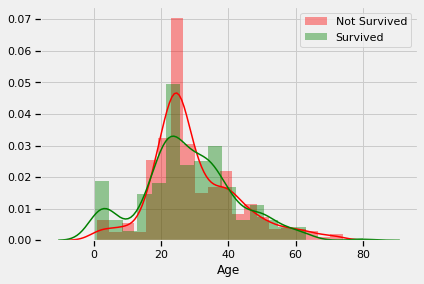

In [42]:
# fig, ax = plt.subplots(figsize=(10, 10))

# Distribution of survival in feature Age
sns.distplot(..., color = 'red', label='Not Survived', hist=True)
sns.distplot(..., color = 'green', label='Survived', hist=True)
plt.legend()

plt.show()

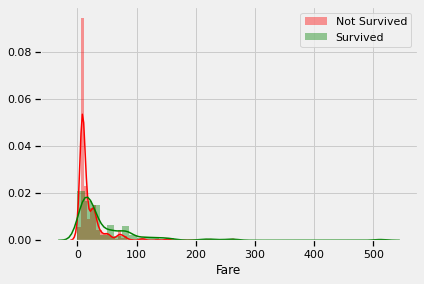

In [43]:
# fig, ax = plt.subplots(figsize=(10, 10))

# Distribution of survival in feature Fare
sns.distplot(..., color = 'red', label='Not Survived', hist=True)
sns.distplot(..., color = 'green', label='Survived', hist=True)
plt.legend()

plt.show()

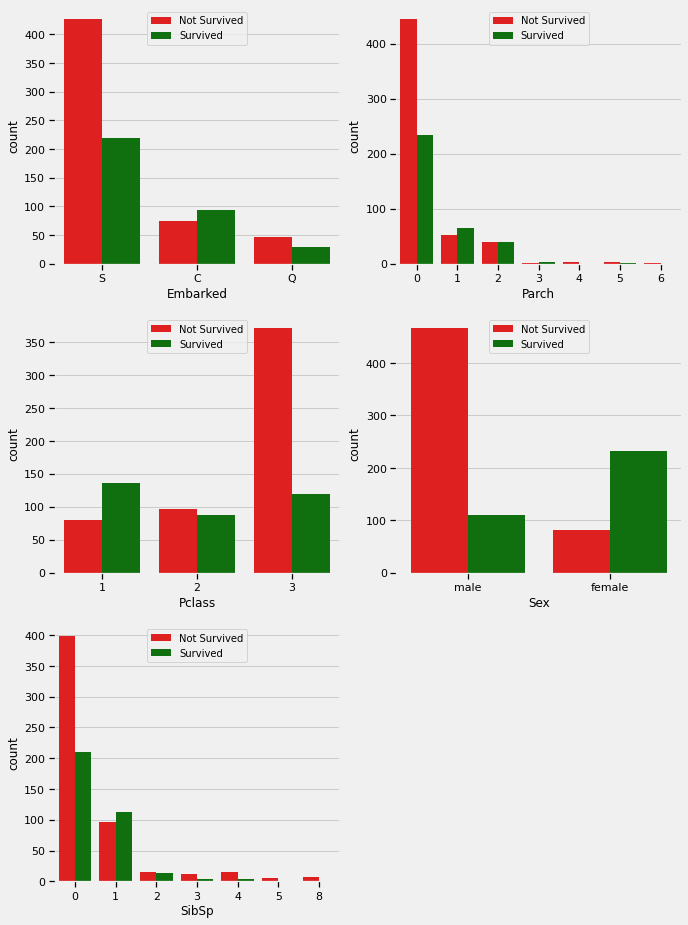

In [70]:
cat_features = ...

fig, axs = plt.subplots(figsize=(10, 15))
# plt.subplots_adjust(right=1, top=1.5)

for i, feature in enumerate(cat_features):    
    plt.subplot(3,2, i+1)
    sns.countplot(x=feature, hue='Survived', palette = ['red', 'green'], data=df_titanic)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 10})

plt.show()

### **Conclusion**
Most features are correlated with each other. This can be used to create new features using feature transformation and feature interaction. 

Target encoding could be very useful due to the high correlations with `Survived` feature.

Categorical features have distinct distributions with different survival rates. Those features can be one-hot encoded and combined with each other to make new features.

## **Feature Engineering**
### **Binning Continuous Features**

```python
pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')[source]
```
Quantile-based discretization function.

Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

#### **Fare**
As we saw, `Fare` is right skewed and survival rate is extremely high on the right end. Let's group them into bins. Let's see how many bins we would need

In [74]:
...

PassengerId
1        (-0.001, 7.854]
2      (39.688, 512.329]
3          (7.854, 10.5]
4      (39.688, 512.329]
5          (7.854, 10.5]
             ...        
887       (10.5, 21.679]
888     (21.679, 39.688]
889     (21.679, 39.688]
890     (21.679, 39.688]
891      (-0.001, 7.854]
Name: Fare, Length: 891, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

In [75]:
...

PassengerId
1        (-0.001, 7.55]
2      (39.688, 77.958]
3         (7.854, 8.05]
4      (39.688, 77.958]
5         (7.854, 8.05]
             ...       
887      (10.5, 14.454]
888      (27.0, 39.688]
889      (21.679, 27.0]
890      (27.0, 39.688]
891       (7.55, 7.854]
Name: Fare, Length: 891, dtype: category
Categories (10, interval[float64]): [(-0.001, 7.55] < (7.55, 7.854] < (7.854, 8.05] < (8.05, 10.5] ... (21.679, 27.0] < (27.0, 39.688] < (39.688, 77.958] < (77.958, 512.329]]

**10** quantile based bins are used for `Fare` feature. 10 bins provide decent amount of information gain. The groups at the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph.

In [76]:
df_titanic['Fare'] = ...

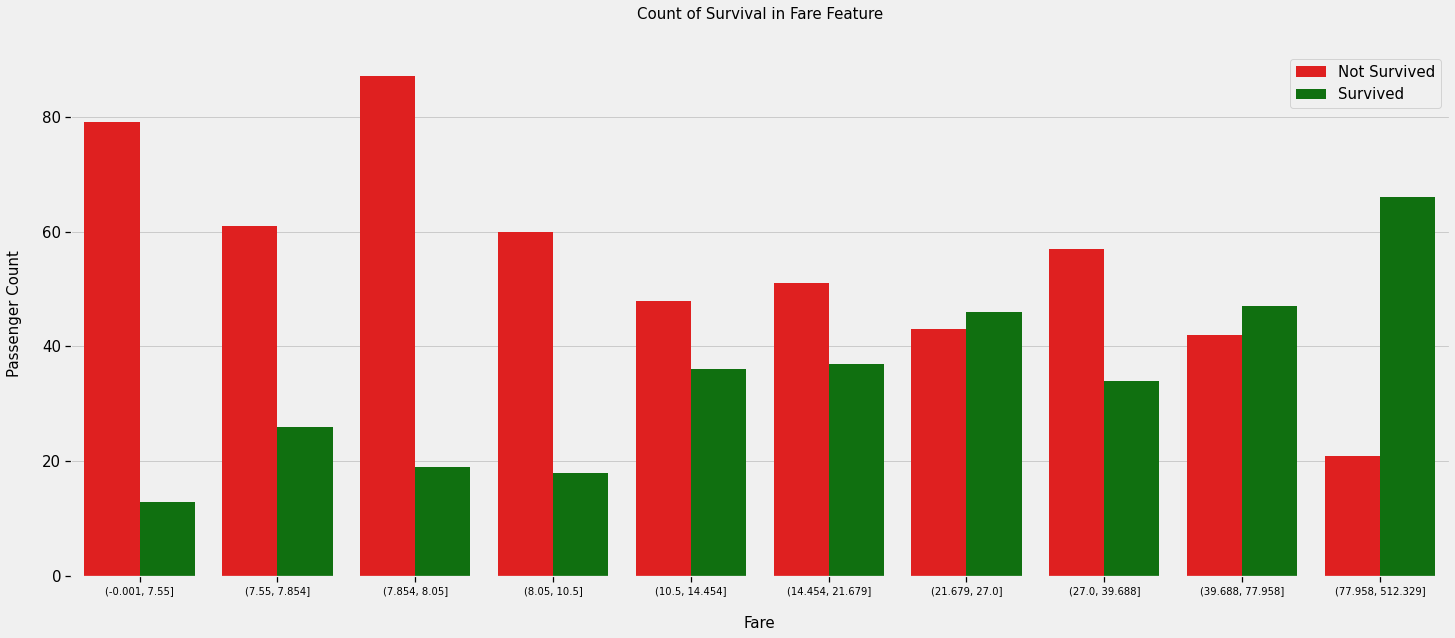

In [82]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(...)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

### Frequency Encoding

`Family_Size` is defined as a new feature by adding `SibSp`, `Parch` and **1**. `SibSp` is the number of siblings and spouse, and `Parch` is the number of parents and children. Those columns are added in order to find the total size of families. Adding **1** at the end, is the current passenger. 

In [78]:
df_titanic['Family_Size'] = ...


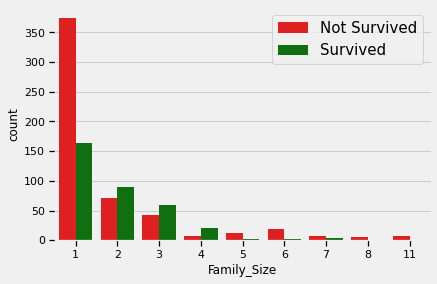

In [84]:
sns.countplot(...)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})



Then we group them based on their size
* Family Size with **1** are labeled as **Alone**
* Family Size with **2**, **3** and **4** are labeled as **Small**
* Family Size with **5** and **6** are labeled as **Medium**
* Family Size with **7** and larger are labeled as **Large**

In [85]:
family_map =...

df_titanic['Family_Size_Grouped'] = ...


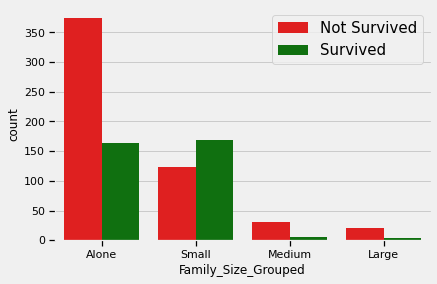

In [90]:
order = ...

sns.countplot(...)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})


In [104]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Survived             891 non-null    int64   
 1   Pclass               891 non-null    int64   
 2   Name                 891 non-null    object  
 3   Sex                  891 non-null    object  
 4   Age                  891 non-null    float64 
 5   SibSp                891 non-null    int64   
 6   Parch                891 non-null    int64   
 7   Ticket               891 non-null    object  
 8   Fare                 891 non-null    category
 9   Embarked             891 non-null    object  
 10  Family_Size          891 non-null    int64   
 11  Family_Size_Grouped  891 non-null    object  
dtypes: category(1), float64(1), int64(5), object(5)
memory usage: 124.9+ KB


# Model Preparation

In [107]:
# Split data into training, validation and test sets
train, test = ...

val, test = ...

print('Train:', train.shape, 'Val:', val.shape, 'Test:', test.shape)

Train: (623, 12) Val: (134, 12) Test: (134, 12)


`StratifiedKFold` is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [109]:
# Define numerical features to use for modelling
num_features = ...

# Define categorical features to use for modelling
cat_features = ...

# Standardize features by removing the mean and scaling to unit variance for the training data
scaler = ...
scaler.fit(...)

def create_features(df):
    """Create a feature set from df."""
    # make a copy of the columns in original df that contain numerical features
    scaled = ...
    
    # Convert numeric features to standard units
    scaled.iloc[:, :] = ...
    
    # Convert categorical features using dummy encoding
    categoricals =...
    
    return ...

# Let's test our function
create_features(train).head()

,Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_Size_Grouped_Alone,...,"Fare_(-0.001, 7.55]","Fare_(7.55, 7.854]","Fare_(7.854, 8.05]","Fare_(8.05, 10.5]","Fare_(10.5, 14.454]","Fare_(14.454, 21.679]","Fare_(21.679, 27.0]","Fare_(27.0, 39.688]","Fare_(39.688, 77.958]","Fare_(77.958, 512.329]"
PassengerId,,,,,,,,,,,,,,,,,,,,,
232,0.000864,0,0,1,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
837,-0.607545,0,0,1,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
640,-0.303340,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
390,-0.911749,0,1,0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
598,1.521886,0,0,1,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0


In [110]:
# logistic regression model
model = ...
model.fit(create_features(train), train['Survived'])

LogisticRegression(penalty='none', random_state=42)

In [111]:
# generate accuracy score
accuracy = ...

# Print score
print('Validation accuracy: {} %'.format(accuracy * 100))

Validation accuracy: 79.1044776119403 %


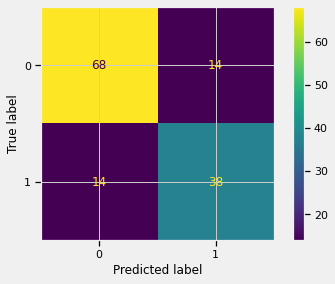

In [113]:
# generate confusion matrix
cm = ...
cm_display = ConfusionMatrixDisplay(cm).plot()

In [115]:
# estimate precision and recall
from sklearn.metrics import precision_score, recall_score, f1_score

# Write your code here
precision = ...
recall = ...

print('Precision: {:.2f} %'.format(precision * 100))
print('Recall: {:.2f} %'.format(recall * 100))

Precision: 73.08 %
Recall: 73.08 %


#### LASSO VS RIDGE Regularization

L1 regularization (also called least absolute deviations) is a powerful tool that can be used to reduce the number of features and limit overfitting. There are many tutorials out there explaining L1 regularization and I will not try to do that here. Instead, this tutorial is show the effect of the regularization parameter C on the coefficients and model accuracy. 

"... Basically, a high C means "Trust this training data a lot", while a low value says "This data may not be fully representative of the real world data, so if it's telling you to make a parameter really large, don't listen to it"..."[[from here]](https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression)

In [116]:
C = ...

for c in C:
    model = ...
    model.fit(...)
    print('C:', c)
    print('Coefficient of each feature:', model.coef_)
    print('Training accuracy:', model.score(create_features(train), train['Survived']))
    print('Validation accuracy:', model.score(create_features(val), val['Survived']))
    print('')

C: 10
Coefficient of each feature: [[-0.57714357  0.70082935  0.         -1.19056046  1.66272113 -1.0284492
   0.12780168  0.         -0.18504097  0.20904311 -1.6559419  -2.2837054
   0.01489146 -0.58779421 -0.51561033  0.         -0.5518633  -0.09540099
   0.07546251  0.35278823  0.0278216   0.88205021  0.35668849]]
Training accuracy: 0.8186195826645265
Validation accuracy: 0.7985074626865671

C: 1
Coefficient of each feature: [[-0.50236966  0.83493477  0.         -1.22346367  1.30539202 -1.24536159
   0.12909762  0.         -0.14700515  0.34793069 -0.63952142 -1.4399432
   0.37994894 -0.35827303 -0.17785854  0.         -0.32908224  0.
   0.          0.13173495 -0.06194534  0.51288959  0.00470648]]
Training accuracy: 0.812199036918138
Validation accuracy: 0.8059701492537313

C: 0.1
Coefficient of each feature: [[-0.17982084  0.40911997  0.         -0.98021898  1.08015676 -0.92565443
   0.          0.          0.          0.          0.          0.
   0.18495133  0.          0.        

L2 regularization (RIDGE)

In [117]:
C = ...

for c in C:
    model = ...
    model.fit(...)
    print('C:', c)
    print('Coefficient of each feature:', model.coef_)
    print('Training accuracy:', model.score(create_features(train), train['Survived']))
    print('Validation accuracy:', model.score(create_features(val), val['Survived']))
    print('')

C: 10
Coefficient of each feature: [[-0.57765492  0.73887444  0.05986887 -1.12145721  1.1839996  -1.5067135
   0.04083324 -0.08727212 -0.27627502  1.07522947 -0.83164213 -1.42998929
   0.86368804 -0.63270268 -0.56636262 -0.05197654 -0.59362485 -0.13751464
   0.05724     0.34049477  0.02414359  0.87645098  0.36113806]]
Training accuracy: 0.8186195826645265
Validation accuracy: 0.7910447761194029

C: 1
Coefficient of each feature: [[-0.52136936  0.79190315  0.09408596 -1.10797708  1.16579395 -1.38778192
   0.08961469 -0.05780088 -0.25380178  0.77267347 -0.565268   -1.12207926
   0.69268581 -0.50028276 -0.36446173  0.0252887  -0.44857106 -0.07559861
   0.05295781  0.26471644 -0.08470254  0.68954707  0.21911871]]
Training accuracy: 0.8154093097913323
Validation accuracy: 0.7985074626865671

C: 0.1
Coefficient of each feature: [[-0.31031444  0.59348695  0.14394326 -0.80838561  0.95792391 -1.02887931
   0.13524044 -0.01840155 -0.18779429  0.152793   -0.1706141  -0.41099942
   0.35786512 -0.2

##### GridSearchCV useful tool

Exhaustive search over specified parameter values for an estimator.

In [122]:
new_train = ...

Accuracy Score : 0.8507462686567164
Precision Score : 0.918918918918919
Recall Score : 0.6666666666666666
F1 Score : 0.7727272727272727


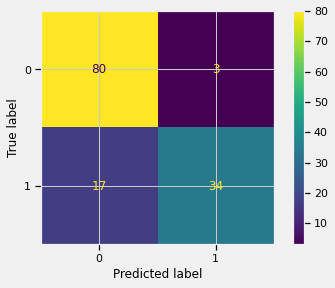

In [123]:
#Grid Search
from sklearn.model_selection import GridSearchCV
# instatiate a  model
model = ...
# establish dict of hyperparameters
grid_values = ...
# set gridsearch
grid_model_acc = ...

# fit data
grid_model_acc.fit(create_features(new_train), new_train['Survived'])

#Predict values based on new parameters
y_pred_acc = grid_model_acc.predict(create_features(test))

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(test['Survived'], y_pred_acc)))
print('Precision Score : ' + str(precision_score(test['Survived'], y_pred_acc)))
print('Recall Score : ' + str(recall_score(test['Survived'], y_pred_acc)))
print('F1 Score : ' + str(f1_score(test['Survived'], y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
cm = confusion_matrix(test['Survived'], y_pred_acc)
cm_display = ConfusionMatrixDisplay(cm).plot()